понятное [видео](https://www.youtube.com/watch?v=bNb2fEVKeEo) со стенфордского курса, из [материалов](https://cs231n.github.io/convolutional-networks) по которому взяты иллюстрации.

Датасет из [курса](https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2004/Week_04_Convolutional_Neural_Networks.ipynb) Даниила Анастасьева.

Использовались [материалы](https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb) из курса Михаила Нефедова.

# Сверточный слой




Желтое - фильтр (= filter,kernel).

Зеленое - входные данные, например, изображение.

Розовое - карта активации (activation map).

Каждый элемент в розовой матрице - результат поэлементного умножения фильтра на числа из области на входных данных.
Обучаемые параметры - элементы фильтра.

![Conv](https://image.ibb.co/e6t8ZK/Convolution.gif)



Чтобы не терять размер матрицы используется паддинг.

![padding](https://3deep.ru/wp-content/uploads/2020/01/keras_conv2d_padding.gif)

from https://3deep.ru/machinelearning/

# Pooling слой  (не обучается)

![Pool](https://cs231n.github.io/assets/cnn/pool.jpeg)
![maxpool](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

# Свертки для текстов устроены немного по-другому. В них на одну размерность меньше.

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)

From [Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

# CNN для обработки текстов



In [1]:
#!pip install torchmetrics

In [2]:
#!pip install ipdb

In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb

### Слова



### Скачивание и подготовка данных

In [2]:
import wget
#wget.download("https://drive.google.com/uc?export=download&id=1z7avv1JiI30V4cmHJGFIfDEs9iE4SHs5")

Колонки датасета:<br>
 <br>
– дата публикации;<br>
– имя автора;<br>
– текст твита;<br>
– класс, к которому принадлежит текст (положительный, отрицательный, нейтральный);<br>
– количество добавлений сообщения в избранное;<br>
– количество ретвитов (количество копирований этого сообщения другими пользователями);<br>
– количество друзей пользователя;<br>
– количество пользователей, у которых данный юзер в друзьях (количество фоловеров);<br>
– количество листов, в которых состоит пользователь.<br>

In [3]:
type_dict = {1:1, -1:0}

In [12]:
positive = pd.read_csv('positive.csv', encoding='utf-8', sep=';', usecols=[3,4], names=['text', 'type'])
negative = pd.read_csv('negative.csv', encoding='utf-8', sep=';', usecols=[3,4], names=['text', 'type'])
data = pd.concat([positive, negative])
data['type'] = [type_dict[i] for i in data['type']]
data.drop_duplicates(inplace=True)

In [14]:
data

,text,type
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1
...,...,...
111918,Но не каждый хочет что то исправлять:( http://...,0
111919,скучаю так :-( только @taaannyaaa вправляет мо...,0
111920,"Вот и в школу, в говно это идти уже надо(",0
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0


In [15]:
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=True)
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [16]:
train_data[train_data.type == 1].shape[0] / train_data.shape[0]

0.5079447203826343

In [17]:
train_data.head(50)

,text,type
0,"эх, ехать на репу пора((\nЗавтра уже выступление.",0
1,"Аллергия вышла,из-за этих тупых мандарин(((((((",0
2,@KompaundTone550 @tatysho власть всегда была б...,1
3,"@Alinockaa А хрен, я гулящая пока, потом насиж...",1
4,"RT @vik_vans: блин, слушала первый мини-альбом...",0
5,Как же не сделать фото на айфон в зеркале:-D h...,1
6,Заебись погулял... Мама пуховик постирала ;((,0
7,#HappyBirthdayLouisfromCIS Почему я мало пиш...,0
8,@cobyisnotalone ладно :(\nмне через полтора ча...,0
9,"@DashaSone вот да, это было бы идеально! Хочу ...",1


Ну что ж... Где-то здесь должен возникнуть препроцессинг, и он возникнет

In [18]:
#!python -m spacy download ru_core_news_sm
import spacy
from tqdm import tqdm
nlp = spacy.load("ru_core_news_sm")

In [23]:
import re
def preprocess(text, nlp):
    doc = nlp(text)
    #postags_stop = ['ADP', 'AUX', 'CCONJ', 'DET', 'INTJ', 'PART', 'PRON', 'PUNCT', 'SCONJ']
    stops = ['\n', '\t']
    lemms = []
    #doc = re.split('[ \n\t,.]', text)
    #print(doc)
    for word in doc:
        if word.lemma_ not in stops:
            #lemms.append(word.strip('#,.*\'\"@!?-^$:;').rstrip('():***').lower())
            lemms.append(word.lemma_.lower())
    return ' '.join(lemms)

In [24]:
preprocess('@GREENloshadka уиии, круто)\nбеларусь, минск\n...	', nlp)

'@greenloshadka уиии , круто ) беларусь , минск ...'

Почему мы можем трогать только train_data? Потому что иначе может попасть что-нибудь из теста. Вероятно, будет не очень заментно, но исключать возможность не стоит, и на уровне слов она больше, чем на уровне символов

In [35]:
texts_of_lemms = []
vocab = Counter()
for text in tqdm(train_data['text']):
    lemma_text = preprocess(text, nlp)
    vocab.update(lemma_text.split(' '))
    texts_of_lemms.append(lemma_text)
print('всего уникальных слов:', len(vocab))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173952/173952 [28:50<00:00, 100.52it/s]

всего уникальных слов: 236059


In [26]:
vocab

Counter({'эх': 697,
         ',': 143900,
         'ехать': 1089,
         'на': 28911,
         'репа': 23,
         'пора': 998,
         '(': 117281,
         'завтра': 4052,
         'уже': 8353,
         'выступление': 117,
         '.': 45625,
         'аллергия': 89,
         'выйти': 903,
         'из': 5395,
         '-': 25650,
         'за': 9271,
         'этот': 7575,
         'тупой': 406,
         'мандарин': 88,
         '@kompaundtone550': 1,
         '@tatysho': 1,
         'власть': 122,
         'всегда': 2344,
         'была': 1543,
         'бандитский': 3,
         'просто': 5102,
         'теперь': 4287,
         'об': 644,
         'знать': 5216,
         'весь': 9016,
         'мир': 742,
         'они': 2711,
         'сами': 223,
         'себя': 3617,
         'имидж': 7,
         'сделать': 2275,
         ')': 111651,
         '@alinockaa': 1,
         'а': 26921,
         'хрен': 203,
         'я': 50091,
         'гулящая': 1,
         'пока': 1758,
    

In [27]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных слов, встретившихся больше 5 раз:', len(filtered_vocab))

уникальных слов, встретившихся больше 5 раз: 18115


In [36]:
clean_texts_of_lemms = []
for text in texts_of_lemms:
    clean_text = []
    for word in text.split():
        if word in filtered_vocab:
            clean_text.append(word)
    clean_texts_of_lemms.append(' '.join(clean_text))

In [42]:
texts_of_lemms[:5]

['эх , ехать на репа пора ( ( завтра уже выступление .',
 'аллергия выйти , из - за этот тупой мандарин ( ( ( ( ( ( (',
 '@kompaundtone550 @tatysho власть всегда была бандитский , просто теперь об знать весь мир . они сами себя имидж сделать )',
 '@alinockaa а хрен , я гулящая пока , потом насидеться дома : dd но сегодня я дома буду спаааааать!:ddd',
 'rt @vik_vans : блин , слушать первый мини - альбом эксо и как то грустно стать . хотеть эра мама :(']

In [43]:
train_data['clean_texts'] = clean_texts_of_lemms

In [44]:
train_data.to_csv('train.csv')

In [45]:
clean_texts_of_lemms_test = []
for text in tqdm(val_data['text']):
    lemma_text = preprocess(text, nlp)
    clean_text = []
    for word in lemma_text.split():
        if word in filtered_vocab:
            clean_text.append(word)
    clean_texts_of_lemms_test.append(' '.join(clean_text))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43488/43488 [06:52<00:00, 105.31it/s]


In [47]:
val_data['clean_texts'] = clean_texts_of_lemms_test
val_data.to_csv('val.csv')

In [48]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for symbol in filtered_vocab:
    word2id[symbol] = len(word2id)

In [49]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [50]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

### Dataset & DataLoader

In [52]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['clean_texts'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split(' ')
        ids = torch.LongTensor([self.word2id[word.lower()] for word in words if word.lower() in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

### создаем итераторы по данным для трейна и теста

In [53]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [54]:
batch = next(iter(train_iterator))

In [55]:
batch[0].shape

torch.Size([64, 35])

In [56]:
[id2word[int(i)] for i in batch[0][0]]

['я',
 'любить',
 'тебя',
 'девочка',
 '!',
 '!',
 '!',
 '@aizadolmatova',
 'ты',
 'рядом',
 '?',
 '(',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [57]:
batch[1]

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

In [60]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [61]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([64, 34])

### CNN model

In [62]:
fm = torch.randn(3, 8, 4) #batch_size, num_filters, seq_len
fm

tensor([[[-0.7822,  0.5771,  0.4306, -0.3864],
         [ 0.4585, -1.3205, -2.0329,  0.0394],
         [ 1.0170,  0.7883, -1.2407, -0.2182],
         [ 1.4919,  0.2329,  0.2809,  0.2891],
         [ 0.4289, -1.2123, -0.0733, -0.4747],
         [ 1.7432, -2.3898, -0.2147, -1.6755],
         [ 0.9011,  1.7878,  0.8172,  0.1693],
         [-0.5749, -1.2151,  0.1544, -1.4641]],

        [[ 0.7682, -1.8860, -0.2762,  0.3652],
         [ 0.9206,  1.0618,  2.0196, -0.5529],
         [ 0.0845,  1.4183,  0.8321, -0.8665],
         [ 0.1181, -2.8269,  1.0087, -2.0653],
         [ 0.3446,  0.5667,  0.9302, -0.2690],
         [ 0.9656,  0.0124, -0.5357,  0.0490],
         [ 2.0479, -1.0736, -1.1618, -0.7393],
         [ 1.3195, -1.1228, -1.1604,  0.0388]],

        [[ 0.2808,  0.5610, -0.7593, -0.8324],
         [ 1.1588,  0.1211, -1.5451,  0.4535],
         [-0.4931, -1.6415,  0.2746,  0.0742],
         [ 0.8807,  0.4609,  1.0995,  0.1729],
         [ 1.4304, -0.3582,  2.1742, -0.7743],
         

In [63]:
mp = torch.nn.MaxPool1d(kernel_size=2, stride=2)
print(mp(fm).shape)
mp(fm)

torch.Size([3, 8, 2])


tensor([[[ 0.5771,  0.4306],
         [ 0.4585,  0.0394],
         [ 1.0170, -0.2182],
         [ 1.4919,  0.2891],
         [ 0.4289, -0.0733],
         [ 1.7432, -0.2147],
         [ 1.7878,  0.8172],
         [-0.5749,  0.1544]],

        [[ 0.7682,  0.3652],
         [ 1.0618,  2.0196],
         [ 1.4183,  0.8321],
         [ 0.1181,  1.0087],
         [ 0.5667,  0.9302],
         [ 0.9656,  0.0490],
         [ 2.0479, -0.7393],
         [ 1.3195,  0.0388]],

        [[ 0.5610, -0.7593],
         [ 1.1588,  0.4535],
         [-0.4931,  0.2746],
         [ 0.8807,  1.0995],
         [ 1.4304,  2.1742],
         [ 0.6367,  0.3256],
         [ 1.1872,  1.5253],
         [ 0.5836,  0.5819]]])

In [64]:
fm.max(2)[0]

tensor([[0.5771, 0.4585, 1.0170, 1.4919, 0.4289, 1.7432, 1.7878, 0.1544],
        [0.7682, 2.0196, 1.4183, 1.0087, 0.9302, 0.9656, 2.0479, 1.3195],
        [0.5610, 1.1588, 0.2746, 1.0995, 2.1742, 0.6367, 1.5253, 0.5836]])

In [71]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concat_bigrams = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        #self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        #batch_size x seq_len
        embedded = self.embedding(text)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        #feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        #feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        # batch_size x filter_count3 x seq_len*
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        #pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        #pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        
        feature_map_concat = self.relu(self.concat_bigrams(concat))
        pooling = feature_map_concat.max(2)[0]
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(pooling)
        logits = self.out(logits)
        
        return logits

In [72]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[ 6730,  4429,  3079,  ...,     0,     0,     0],
        [ 4675,  8143, 11223,  ...,     0,     0,     0],
        [ 9558, 17855,   189,  ...,     0,     0,     0],
        ...,
        [17228,   189, 17202,  ...,     0,     0,     0],
        [10350,  5507, 11223,  ...,     0,     0,     0],
        [11088, 10655, 11179,  ...,     0,     0,     0]])


In [73]:
print(batch)

tensor([[ 6730,  4429,  3079,  ...,     0,     0,     0],
        [ 4675,  8143, 11223,  ...,     0,     0,     0],
        [ 9558, 17855,   189,  ...,     0,     0,     0],
        ...,
        [17228,   189, 17202,  ...,     0,     0,     0],
        [10350,  5507, 11223,  ...,     0,     0,     0],
        [11088, 10655, 11179,  ...,     0,     0,     0]])


In [74]:
y

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.]])

In [75]:
model = CNN(len(id2word), 64)
output = model(batch)
print(output)

tensor([[0.5455],
        [0.5770],
        [0.5532],
        [0.5560],
        [0.5638],
        [0.5450],
        [0.5493],
        [0.5404],
        [0.5723],
        [0.5844],
        [0.5522],
        [0.5637],
        [0.5573],
        [0.5497],
        [0.5386],
        [0.5305],
        [0.5666],
        [0.5911],
        [0.5863],
        [0.5430],
        [0.5423],
        [0.5724],
        [0.5448],
        [0.5582],
        [0.5664],
        [0.5526],
        [0.5589],
        [0.5623],
        [0.5676],
        [0.5358],
        [0.5463],
        [0.5492],
        [0.5465],
        [0.5400],
        [0.5802],
        [0.5690],
        [0.5823],
        [0.5604],
        [0.5707],
        [0.5593],
        [0.5849],
        [0.5785],
        [0.5368],
        [0.5586],
        [0.5561],
        [0.5798],
        [0.5447],
        [0.5866],
        [0.5704],
        [0.5653],
        [0.5837],
        [0.5681],
        [0.5381],
        [0.5530],
        [0.5857],
        [0

In [76]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.7036, grad_fn=<BinaryCrossEntropyBackward0>)

In [77]:
f1(output, y.long())

tensor(0.6383)

### training loop, логика обучения и валидации

теперь нам нужны функции для обучения и валидации,
каждый вызов функции - одна эпоха обучения 

За одну эпоху нам надо для каждого батча:

-- применить к нему модель, 

-- посчитать значение функции потерь, 

-- посчитать градиенты,

-- обновить веса (параметры модели)


In [78]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [79]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

### инициализируем модель, задаем оптимизатор и функцию потерь

In [87]:
model = CNN(len(word2id), 64)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### запуск обучения!

In [89]:
%%time
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(3):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.029679662400848666
Train loss: 0.028911525532986843
Train loss: 0.029187862606284472
Train loss: 0.028946883775792548
Train loss: 0.028674452965190236

Evaluating on train...
Val loss: 0.026262281669331, Val f1: 0.9884724617004395
Val loss: 0.0253663602084948, Val f1: 0.9879990816116333
Val loss: 0.025473053628036466, Val f1: 0.9877691864967346
Val loss: 0.025181002846630187, Val f1: 0.9878318309783936
Val loss: 0.025178827590686834, Val f1: 0.9877967834472656

Evaluating on test...
Val loss: 0.02719665092709302, Val f1: 0.9934788346290588
Val loss: 0.02837283679775108, Val f1: 0.9887653589248657
Val loss: 0.029119534590527178, Val f1: 0.9869243502616882
Val loss: 0.029728626860980736, Val f1: 0.9861316680908203
Val loss: 0.029971319913630064, Val f1: 0.9856427311897278

starting Epoch 1
Training...
Train loss: 0.02500744269054446
Train loss: 0.024676515495065682
Train loss: 0.025023511601233603
Train loss: 0.025026446464606583
Train loss: 0.

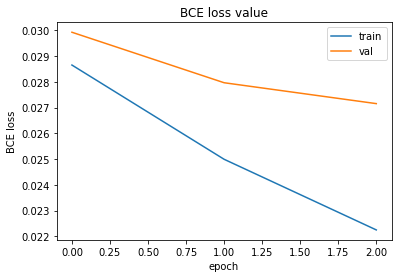

In [90]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

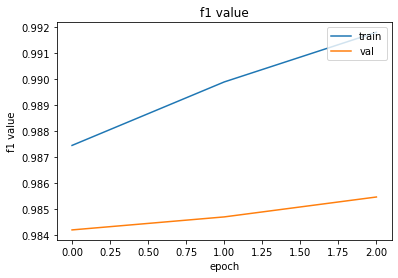

In [91]:
import matplotlib.pyplot as plt
plt.plot([i.cpu() for i in f1s])
plt.plot([i.cpu() for i in f1s_eval])
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Мы поменяли learning rate и добавили дропаут, кажется, стало лучше

Для анализа ошибок можно посмотреть на те примеры, которые мы (не)правильно предсказываем

In [94]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [95]:
fp, fn, tp, tn = predict(model, val_iterator)

In [99]:
print('positive', tp[:10])

positive ['вот да , ибо мой творческий натура не на простор контакт в ) :d', 'q : посмотреть страница вк :) a :', 'дуу бе шд тэ хэхэ дуу :-))', 'весь поздравлять с день администратор :)', '. :)', 'он смочь сделать это вечер . :-) # instantfollowback', 'была вчера в " " . там целый поляна - " рождественский звезда " . красотища ! :)', 'когда он писать в твой тетрадка , когда ты это восхитительный :*', 'энэ яасан намайг дээр бсан юм бэ : -):-):- )', 'мне всегда нравиться парень , которые старший меня :d я с ним иногда в вк переписываться , но в реал ни разу не разговаривать']


In [101]:
print('false_n', fn[:10])

false_n ['g красота самая главный неё нельзя !', 'rt @igorg1975 : и медаль после : t ”', 'rt : а мне очень _', 'нифига ты тоже хотеть так', 'крутой варежка номер день !', 'работа кать , кофта с высокий горло нет ?', 'красавчик по матану кстати тоже не , по физика тоже не ....', 'rt : @ocheshuenaya ...', ', - ведь лдпр по тихоньку захватывать территория', 'rt @lovkovusha : @mistermakaron не смотреть сериал новый серия выйти']


In [103]:
print('false_p:', fp[:10])

false_p: ['rt : смешной', 'что вообще сегодня в метро', '@cheko_ov я очень рад ! очень - очень - очень рад !', 'блять . сейчас контрольный работа по', 'придурок , стать слушать за 2 неделя до себя это не простить ! да , надо билет купить , но это после', 'наш следующий лето увидеть свой друг , родных , , дом , мой комната , ждать', 'че ты же мешать тебе', 'ой про весь плохой ... мочь на каникулах подойти к', 'так тянуть написать ему , любить мой , но сахар то родной ... и от это грустный', '@do_or_die_xxx это еще что , вот иногда я напишу какой - нибудь твит с телефон , отправлять , а вместо того чтобы отправить он выходить из тви -_-']


In [104]:
print('true_n:', tn[:10])

true_n: ['здесь стремно , такой звук :(', 'ну вот опять :( аж глаз ...', 'бляха , шо щас і , а вона не ( ( (', '# короче еще больше , чем ожидаться ( ( ( (', 'бля . зачем я это увидеть (', 'мороз стоять жуткий ( # крещение # # # photo # # # # путешествие @ …', 'полночь башка . и утро совсем разбить (', 'пойти выпью : ~ ( # ru_ff # ff_ru', 'смотреть концерт и понимать , что а мочь я так и не попасть на его концерт . ( ( ( (', 'блиииин , завтра и история ( ( ( (']


А почему так хорошо? А потому, что скобочки не удаляли, а их в русскоязычном сегменте интернета часто используют как смайлики (или в составе других текстовых смайликов)